### 0. Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

from sklearn.metrics import roc_curve, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import average_precision_score               # computes AUPRC

import warnings
warnings.filterwarnings('ignore')

### 1. Load data

This project used the famous "creditcard" dataset from Kaggle.  

It contains only numerical input variables from a PCA transformation. Features V1, V2, … V28 are the principal components obtained with PCA. Only 'Time' and 'Amount' are raw. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount.

In [116]:
df = pd.read_csv('creditcard.csv')
#df.head()
#df.info()

### 2. EDA and Preprocessing

Checked:
 - missing value  
 - imbalance  
 - whether data had been standardized or normalized   
 - the 2 raw number columns by visualizing  
 - No need to check corr because data were already PCA-ed
    
Preprocessed:
 - Processed the 2 columns of raw data  
 - Split data into train/val/test. Kept solely normal transactions data for training and validation. Made sure test data contain all the fraud data
 - feature scaling using Standardization

Visualized:    
 - "Amount" distribution by "Time" and "Class"       
 - PCA of standardized data by train/test and "Class"    
 - t-SNE clustering  of standardized data by train/test and "Class"  


#### 2.0 missing values

In [94]:
# check missing value for each feature
df.isnull().sum()

# calculate total missing value for all features
total_missing_values = df.isnull().sum().sum()
print(f"Total number of missing values: {total_missing_values}")

Total number of missing values: 0


#### 2.1 imbalance check

In [ ]:
# check for imbalance
class_counts = df["Class"].value_counts()
print(class_counts)

print(f"Proportion of fraud cases: {(class_counts[1] / class_counts.sum())*100:.4f}%")

Class
0    284315
1       492
Name: count, dtype: int64
Proportion of fraud cases: 0.1727%


Data is severely imbalanced. Fraud is scarce, only takes 0.17%. True to description.

#### 2.2 check for scaling

In [96]:
# check if data had been standardized or normalized before provided
for col in df.columns:
    print(f"{col} mean: {np.mean(df[col])}, std: {np.std(df[col])}")

Time mean: 94813.85957508067, std: 47488.062585499334
V1 mean: 1.1751608993193201e-15, std: 1.9586923652174189
V2 mean: 3.384974329561085e-16, std: 1.6513056804786777
V3 mean: -1.379536707896593e-15, std: 1.5162523432763153
V4 mean: 2.094852037917049e-15, std: 1.4158660892755088
V5 mean: 1.0218790428863653e-15, std: 1.38024431090289
V6 mean: 1.4944981002213093e-15, std: 1.3322687508539335
V7 mean: -5.620334735875009e-16, std: 1.2370914263703792
V8 mean: 1.1496139232471609e-16, std: 1.1943508058914716
V9 mean: -2.4141892388190378e-15, std: 1.0986301604917852
V10 mean: 2.238553778322944e-15, std: 1.0888478538435995
V11 mean: 1.7244208848707414e-15, std: 1.0207112357718877
V12 mean: -1.2454150835177577e-15, std: 0.9991996353557976
V13 mean: 8.23889978327132e-16, std: 0.9952724828452344
V14 mean: 1.2134813634275587e-15, std: 0.9585939283692614
V15 mean: 4.866698941746315e-15, std: 0.915314404703279
V16 mean: 1.4362190610566962e-15, std: 0.876251349059508
V17 mean: -3.768178970643472e-16, s

For V1~V28, although the means are close to 0, the stds range from 1.95 to 0.33. The data still need to be standardized.

#### 2.3 visualize Amount by Time and Class

In [100]:
# find upper limit of Amount (i.e. ylim) for scatter plot
print(df[df["Class"]==1]["Amount"].max())

2125.87


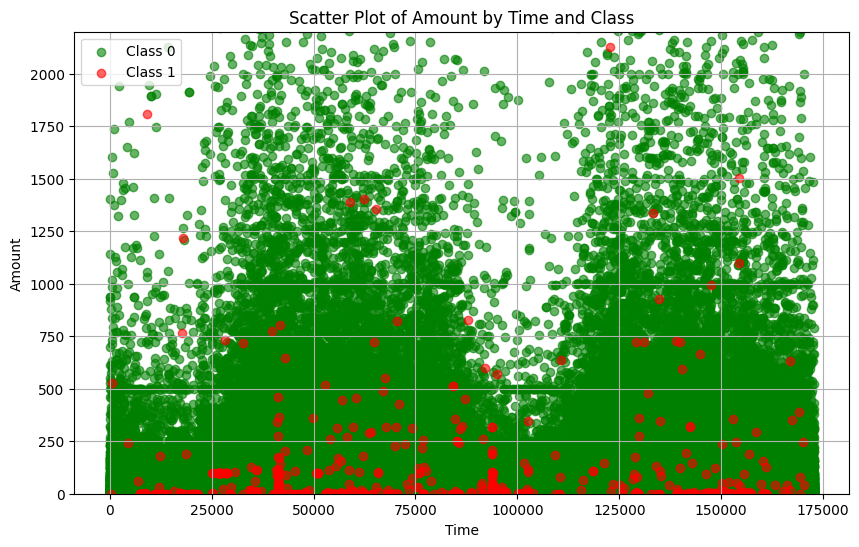

In [119]:
# visualize Amount by Time and Class
class_0 = df[df["Class"] == 0]
class_1 = df[df["Class"] == 1]

plt.figure(figsize=(10, 6))
plt.scatter(class_0["Time"], class_0["Amount"], color='green', alpha=0.6, label='Class 0')
plt.scatter(class_1["Time"], class_1["Amount"], color='red', alpha=0.6, label='Class 1')

plt.ylim(0, 2200)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Scatter Plot of Amount by Time and Class')
plt.legend()
plt.grid(True)
plt.show()


#### 2.4 data preprocessing - the raw number columns

In [7]:
# Drop "Time" column
df = df.drop("Time", axis=1)

# log transform "Amount" to reduce skewness
df["Log_Amount"] = np.log1p(df["Amount"])
df.drop("Amount", axis=1, inplace=True)

#### 2.5 data preprocessing - split data
To prevent data leakage, split data before further data pre-processing.  

Use only non-fraud data to train the autoencoder.   
> training data: 70% of normal transactions data, features only  
> validation data: 15% of normal transactions data, features only  
> test data: all the fraud transactions data, and 15% of normal transactions data, features and label

In [ ]:
# split data for training, validation, and testing
df_0 = df[df["Class"] == 0]
df_1 = df[df["Class"] == 1]

test_0 = df_0.sample(frac=0.15, random_state=42)
test = pd.concat([df_1, test_0])

train_0 = df_0.drop(test_0.index).drop("Class", axis=1)
train = train_0.sample(frac=0.7, random_state=42)
val = train_0.drop(train.index)

print(train.shape, val.shape, test.shape)

(169168, 29) (72500, 29) (43139, 30)


#### 2.6 data preprocessing -  feature scaling by StandardScaler

In [9]:
# Standardize features
feature_cols = [col for col in train.columns]

scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train[feature_cols]), columns=feature_cols, index=train.index)
val_scaled = pd.DataFrame(scaler.transform(val[feature_cols]), columns=feature_cols, index=val.index)
test_scaled = pd.DataFrame(scaler.transform(test[feature_cols]), columns=feature_cols, index=test.index)

# restore labels for test data
test_scaled['Class'] = test['Class'].values

#### 2.7 PCA, visualize the 2 most principal components  

This step here is not for further dimension reduction or feature selection, but to visualize the 2 most principal components and see if Class = 0 and Class = 1 naturally cluster apart, if there is any patterns or outliers, etc.

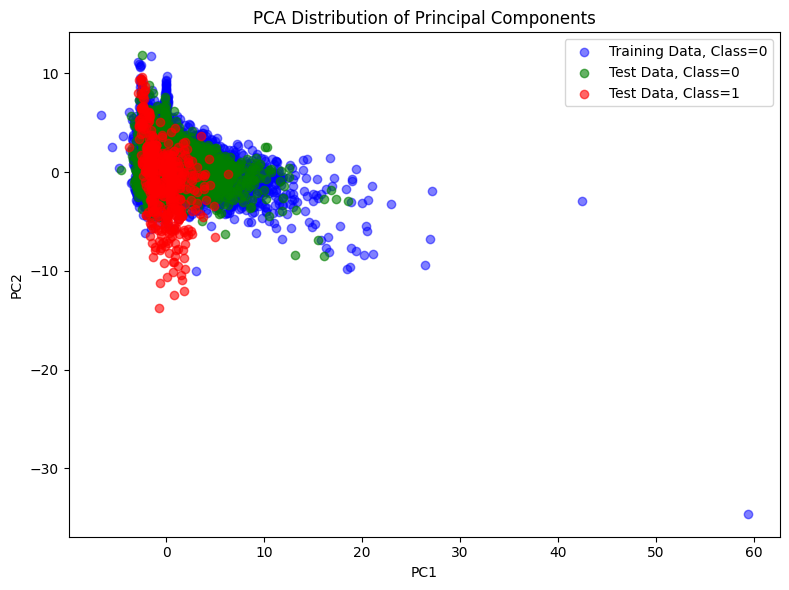

In [103]:
# PCA on standardized data
test_features = test_scaled.drop("Class", axis=1)
test_labels = test_scaled["Class"]

# PCA
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_features)

# visualize
plt.figure(figsize=(8, 6))

plt.scatter(train_pca[:, 0], train_pca[:, 1], c='blue', alpha=0.5, label='Training Data, Class=0')
plt.scatter(test_pca[test_labels == 0, 0], test_pca[test_labels == 0, 1], c='green', alpha=0.6, label='Test Data, Class=0')
plt.scatter(test_pca[test_labels == 1, 0], test_pca[test_labels == 1, 1], c='red', alpha=0.6, label='Test Data, Class=1')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Distribution of Principal Components')
plt.legend()
plt.tight_layout()
plt.show()



#### 2.8 t-SNE, visualize local clusters

t-SNE on the large dataset is very computationally demanding. To save time, normal data were sampled. All fraud data were included.

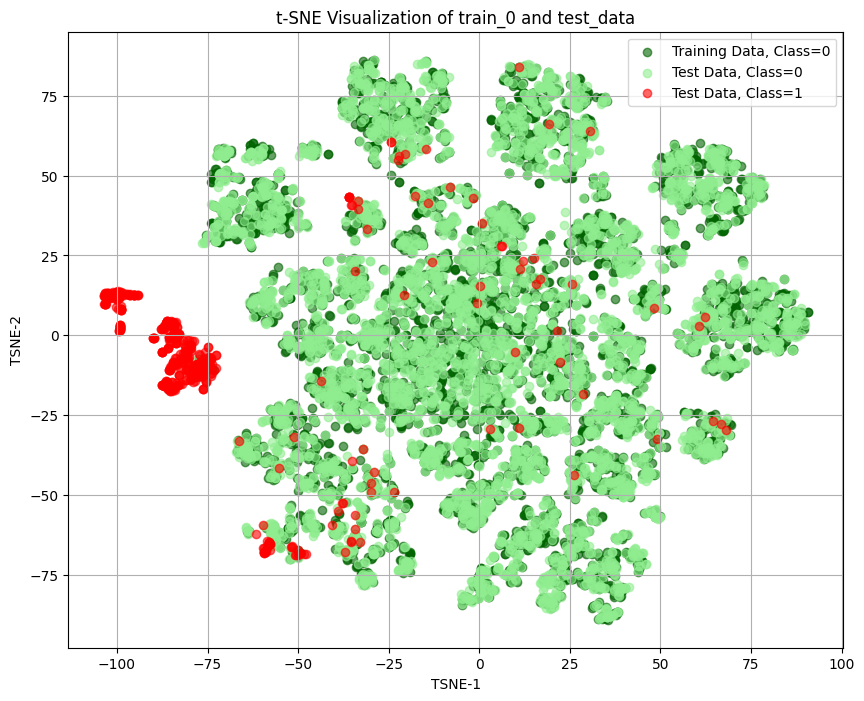

In [ ]:

# use all the fraud data and sample normal data
test_fraud = test_scaled[test_scaled['Class'] == 1]
train_normal_sample = train_scaled.sample(n=5000, random_state=42)
test_normal_sample = test_scaled[test_scaled['Class'] == 0].sample(n=5000, random_state=42)

# combine the data
combined_data = pd.concat([train_normal_sample, test_normal_sample, test_fraud], ignore_index=True)

# keep only the features
features = combined_data.drop(columns=['Class'])

# t-SNE dimension reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(features)

# create t-SNE result column
combined_data['TSNE-1'] = tsne_results[:, 0]
combined_data['TSNE-2'] = tsne_results[:, 1]

# add back label column
labels = []
for i in range(len(combined_data)):
    if i < len(train_normal_sample):
        labels.append('Training Data, Class=0')
    elif i < len(train_normal_sample) + len(test_normal_sample):
        labels.append('Test Data, Class=0')
    else:
        labels.append('Test Data, Class=1')
combined_data['Label'] = labels

# visualize
plt.figure(figsize=(10, 8))
colors = {'Training Data, Class=0': 'darkgreen', 'Test Data, Class=0': 'lightgreen', 'Test Data, Class=1': 'red'}

for label in colors:
    subset = combined_data[combined_data['Label'] == label]
    plt.scatter(subset['TSNE-1'], subset['TSNE-2'], c=colors[label], label=label, alpha=0.6)

plt.title('t-SNE Visualization of train_0 and test_data')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend()
plt.grid(True)
plt.show()


### 3. Set up AutoEncoder Neural Network Structure

Based on data dimension, complexity, and size, I used 2 hidden layers for both encoder and decoder.

In [ ]:
# define the key parameters
batch_size = 100
original_dim = 29
intermediate_dim1 = 20 
intermediate_dim2 = 10
latent_dim = 5
epochs = 50
epsilon_std = 1.0

In [105]:
# Encoder
# input layer
x = Input(shape=(original_dim,), name="input")
# 2 encoding hidden layers
h1 = Dense(intermediate_dim1, activation="tanh", name="encoding1", activity_regularizer=regularizers.l1(1e-4))(x)
h = Dense(intermediate_dim2, activation='relu', name="encoding")(h1)
# bottleneck layer, define the mean of the latent space
z = Dense(latent_dim, activation='relu', name="encoder_out")(h)
# assemble the encoder into a keras model
encoder = Model(x, z, name="encoder")
# print out summary of what we just did
encoder.summary()   

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoding1 (Dense)               │ (None, 20)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoding (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_out (Dense)             │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 865 (3.38 KB)

 Trainable params: 865 (3.38 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
# Decoder
# input layer
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# 2 decoding hidden layers
decoder_h1 = Dense(intermediate_dim2, activation='relu', name="decoder_h1")(input_decoder)
decoder_h = Dense(intermediate_dim1, activation='relu', name="decoder_h")(decoder_h1)
# output layer, decoded to the original dimension
x_decoded = Dense(original_dim, activation='tanh', name="flat_decoded")(decoder_h)
# assemble the decoder into a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_h1 (Dense)              │ (None, 10)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_h (Dense)               │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_decoded (Dense)            │ (None, 29)             │           609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 889 (3.47 KB)

 Trainable params: 889 (3.47 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
# AutoEncoder
# x -> encoder -> z -> decoder -> x_reconstructed
x_reconstructed = decoder(encoder(x))
# link the input and the final output
autoencoder = Model(x, x_reconstructed)
# print out what the whole model looks like
autoencoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 5)              │           865 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 29)             │           889 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,754 (6.85 KB)

 Trainable params: 1,754 (6.85 KB)

 Non-trainable params: 0 (0.00 B)

### 4. Train the AutoEncoder

In [34]:
# train the AutoEncoder Neural Network
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = autoencoder.fit(train_scaled, train_scaled,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(val_scaled, val_scaled),
                    verbose=1).history

Epoch 1/50
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.8163 - val_loss: 0.7469
Epoch 2/50
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7226 - val_loss: 0.7199
Epoch 3/50
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7034 - val_loss: 0.7086
Epoch 4/50
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6930 - val_loss: 0.6983
Epoch 5/50
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6821 - val_loss: 0.6836
Epoch 6/50
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6701 - val_loss: 0.6740
Epoch 7/50
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6611 - val_loss: 0.6686
Epoch 8/50
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6525 - val_loss: 0.6580
Epoch 9/50
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6478 - val_loss: 0.6559
Epoch 10/50
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6426 - val_loss: 0.6501
Epoch 11/50
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.6406 - val_loss: 0.6506
Epoch 12/50
1692/1692 ━━━━━━━

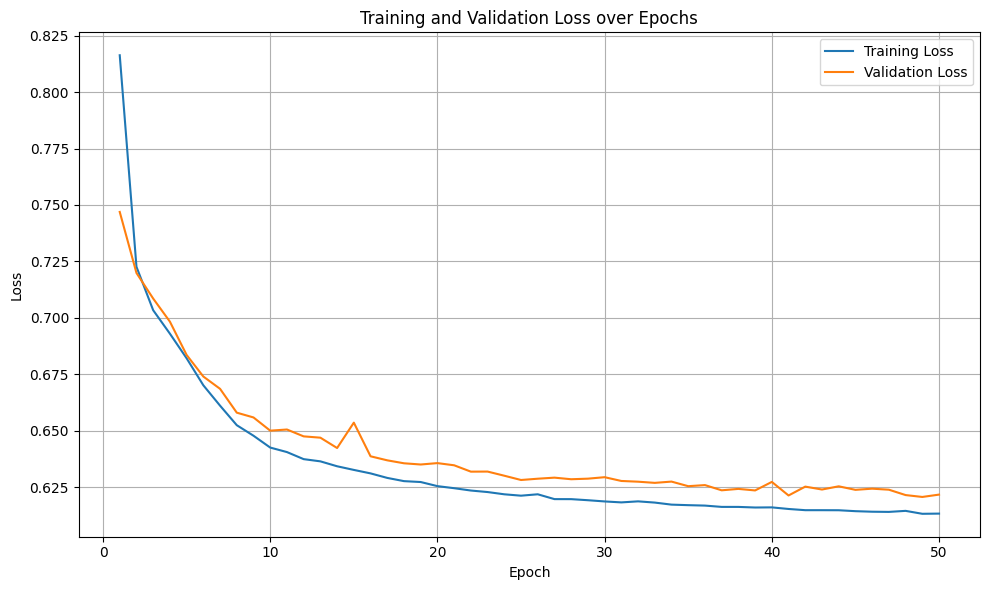

In [35]:
# visualize loss and val_loss
# extract loss and val_loss
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)

# plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Model converges well and generalizes well.

### 5. Reconstruction, and Reconstruction Error

#### 5.0 reconstruction

In [112]:
X_test_scaled = test_scaled.drop("Class", axis=1)
y_test_scaled = test_scaled["Class"]

# Reconstruction, i.e. prediction 
predictions = autoencoder.predict(X_test_scaled)

1349/1349 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step


#### 5.1 reconstruction error

In [113]:
# Reconstruction error
mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)
error_df = pd.DataFrame({"reconstruction_error": mse, "true_class": y_test_scaled})

# Reconstruction Error on All, Normal and Fraud classes
for name, df in {
    "All": error_df,
    "Normal": error_df[error_df["true_class"] == 0],
    "Fraud": error_df[error_df["true_class"] == 1]
}.items():
    mean, std = df["reconstruction_error"].mean(), df["reconstruction_error"].std()
    print(f"{name:<7} → Mean: {mean:.4f}, Std: {std:.4f}")


All     → Mean: 0.9439, Std: 5.0533
Normal  → Mean: 0.6662, Std: 2.7613
Fraud   → Mean: 25.0161, Std: 31.5262


As is expected, normal group has small Reconstruction Error, while fraud group has very large Reconstruction Error.

#### 5.2 log-scaled visualization

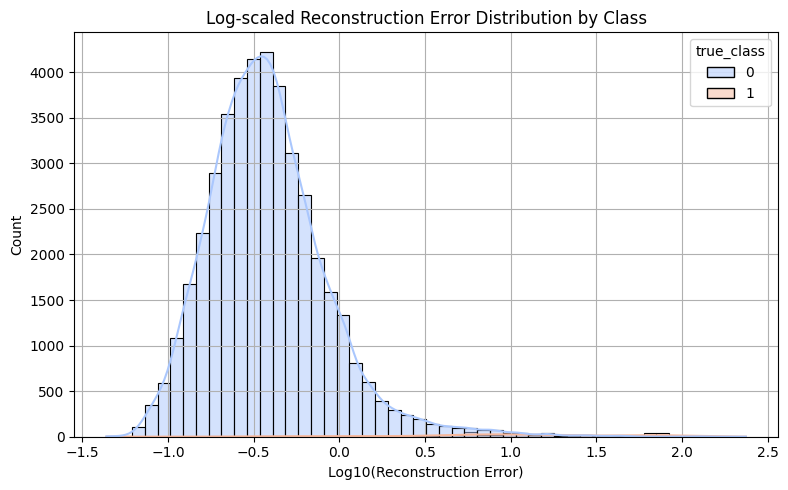

In [ ]:
''' 
# plot of reconstruction error is extremely skewed. Since all values are positive, use log transformation.
'''

# log transformation
error_df["log_error"] = np.log10(error_df["reconstruction_error"] + 1e-8)

# plot log-scaled reconstruction error distribution by class
plt.figure(figsize=(8, 5))
sns.histplot(
    data=error_df,
    x="log_error",
    hue="true_class",
    bins=50,
    kde=True,
    palette="coolwarm"
)
plt.title("Log-scaled Reconstruction Error Distribution by Class")
plt.xlabel("Log10(Reconstruction Error)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

While some fraud's (log-scaled) Reconstruction Errors blend in with the normal's, the majority of them neatly clustered apart from the normal's.

### 6. Threshold and Classification

In [123]:
# Use ROC to find threshold of Reconstruction Error
fpr, tpr, thresholds = roc_curve(y_test_scaled, mse)

# Youden's J statistic = TPR - FPR，find the max diff and corresponding threshold
j_scores = tpr - fpr
best_threshold = thresholds[j_scores.argmax()]
print(f"Best threshold selected by ROC: {best_threshold}")

Best threshold selected by ROC: 1.7411761287612586


In [124]:
# classification by mse threshold
error_df["predicted_class"] = (error_df["reconstruction_error"] > best_threshold).astype(int)

### 7. Evaluation

#### 7.0 Confusion Matrix

In [ ]:
# Confusion Matrix
cm = confusion_matrix(error_df['true_class'], error_df['predicted_class'])
print(f"Confusion Matrix:\n{cm}")

Confusion Matrix:
[[40883  1764]
 [   61   431]]


#### 7.1 Precision, Recall, F1 Score

In [85]:
# Precision, Recall, F1
precision = precision_score(error_df['true_class'], error_df['predicted_class'])
recall = recall_score(error_df['true_class'], error_df['predicted_class'])
f1 = f1_score(error_df['true_class'], error_df['predicted_class'])

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.1814
Recall:    0.8740
F1 Score:  0.3005


#### 7.2 ROC curve and AUC

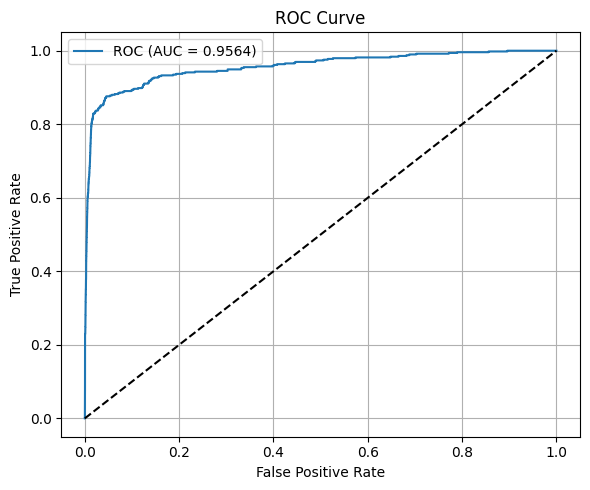

In [86]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(error_df['true_class'], error_df['reconstruction_error'])
auc = roc_auc_score(error_df['true_class'], error_df['reconstruction_error'])

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### 7.3 Precision-Recall Curve and AUPRC

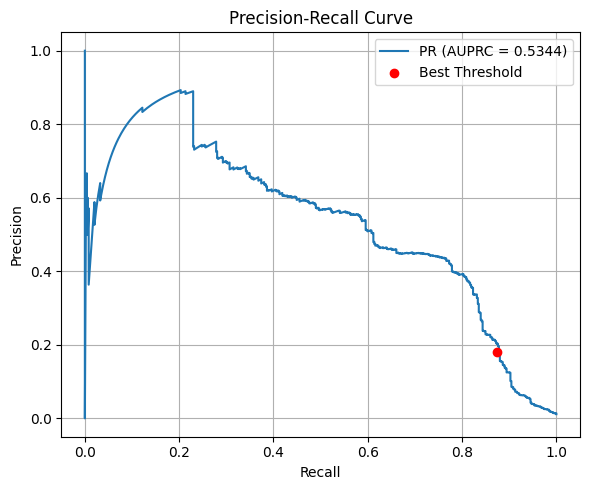

In [135]:
# AUPRC, and Precision-Recall Curve
prec, rec, _ = precision_recall_curve(error_df['true_class'], error_df['reconstruction_error'])
auprc = average_precision_score(error_df['true_class'], error_df['reconstruction_error'])

# specify the best point
best_precision = 0.1814
best_recall = 0.8740

plt.figure(figsize=(6, 5))
plt.plot(rec, prec, label=f'PR (AUPRC = {auprc:.4f})')
plt.scatter(best_recall, best_precision, color='red', label='Best Threshold', zorder=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show() 


#### 7.4 Conclusions

With limitations of data, this AutoEncoder Neural Network model still gives excellent AUC (0.9564) and decent AUPRC (0.5344).

Using the threshold chosen by ROC, the model gives excellent Recall (0.8740) and decent F1 score. Different threshold can be chosen according to demand on higher precision or higher recall. The Precision-Recall Curve provides a clear reference.

### 8. Space to Explore Further

 - 1. "Time" column was eliminated based on data description and visualization. If converted to hour:minute:second form and then split it into 3 columns, there might be useful information.   
 - 2. Since the data is in time series, RNN LSTM is also an approach to consider. But given it's only 2 days' data, I am not sure how much benefit LSTM could bring, that's why I didn't choose LSTM. Still worth exploring.
 - 3. Many classical ML models, e.g. RF, XGBoosting, Logistic Regression, etc. can deal with classification problem. They would need SMOTE to oversample the fraud data. I didn't choose these algorithms because the Class=1 is too scarce. Still worth exploring.
 - 4. Hyperparameter tuning is also worth exploring.
 - 5. May try other split ratio, giving training more data, e.g. 80/10/10 split
 - 6. This data contains only numeric features. In real world, can utilize non-numeric features as well.